In [2]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model
import sklearn
import array
import pickle
import tarfile
from urllib.request import urlretrieve
import os
import sys
from os import listdir
import nltk
from os.path import isfile, join
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import plot_model
import pandas as pd
%matplotlib inline

In [3]:
def getTextFromCooc(pathToFile):
    with open(pathToFile, 'r', encoding='utf8') as f:
        indexRow = 0
        headerText = []
        docs = []
        for row in f:
            if(indexRow == 0):
                for word in row.split(','):
                    headerText.append(word)
            else:
                indexNumber = 0
                isStringCreated = False
                for word2 in row.split(','):
                    if(indexNumber == 0):
                        pass
                    else:
                        if int(word2) == 1:
                            if(isStringCreated == False):
                                string = ''
                                isStringCreated = True
                            if(string == ""):
                                string = headerText[indexNumber-1]
                            else:
                                string = string +' '+headerText[indexNumber-1]
                    indexNumber += 1
                #string = string[2:]
                docs.append(string)
                docs = [s.replace("'", '"') for s in docs] # remove all the 8s 
            indexRow +=1
    with open('./docs/textTheGoodScents.txt','wb') as f:
        pickle.dump(docs, f)
    return [docs,headerText]

In [4]:
docs,headerText = getTextFromCooc('./TGS/dataTGS.csv')
print(headerText)

['\ufeffabricot', 'absinthe', 'acajou', 'acétique', 'acétone', 'acrylate', 'agneau', 'agrume', 'ail', 'airelle', 'alcool', 'aldéhyde', 'algue', 'alliacé', 'amande', 'amandeamère', 'amandetorréfiée', 'ambregris', 'ambrette', 'ananas', 'aneth', 'angélique', 'animal', 'anis', 'anisé', 'artichaut', 'asefétide', 'asperge', 'aubépine', 'babeurre', 'bacon', 'baie', 'balsamique', 'banane', 'bananeverte', 'barbeàpapa', 'basilic', 'benjoin', 'bergamote', 'beurre', 'beurredecacahuète', 'beurrerance', 'bière', 'bœufcuit', 'bois', 'boisbrûlé', 'boisdagar', 'boisé', 'bonbon', 'boronia', 'bouillon', 'bouillondelégumes', 'bouillondeviande', 'bourgeondecassis', 'brandy', 'brûlé', 'buchu', 'cacahuète', 'cacao', 'café', 'calamus', 'camomille', 'camphre', 'canneberge', 'cannelle', 'caoutchouc', 'câpres', 'capucine', 'carambole', 'caramel', 'caramelaubeurre', 'carbonisé', 'cardamome', 'carotte', 'carvi', 'carvone', 'cassis', 'castoréum', 'cèdre', 'céréale', 'cerfeuil', 'cerise', 'chamallow', 'champignon', 

In [5]:
v_size = 381
tokenizer = Tokenizer(num_words=v_size, oov_token='UNK')
tokenizer.fit_on_texts(docs)

In [6]:
generate_cooc = False
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    meanLen = 0
    meanNumber = 0
    for sequence in sequences:
        meanLen += len(sequence)
        meanNumber +=1
    meanLen = meanLen/meanNumber
    window_size = round(meanLen)
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
            context_window = sequence[i-window_size: i+window_size+1]
            distances = np.abs(np.arange(-window_size, window_size+1))
            distances[window_size] = 1.0
            nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
            nom[window_size] = 0.0
            if use_weighting:
                cooc_mat[wi, context_window] += nom/distances    # Update element
            else:
                cooc_mat[wi, context_window] += nom
    
    return cooc_mat    

if not generate_cooc:
    cooc_mat = generate_cooc_matrix(docs, tokenizer, 4, v_size, False)
    print("Generated......")
    cooc_mat
    save_npz(os.path.join('datasets','cooc_mat.npz'), cooc_mat.tocsr())
else:
    cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz')).tolil()
    print('Cooc matrix of type {} was loaded from disk'.format(type(cooc_mat).__name__))

text = tokenizer.sequences_to_texts([[2, 145, 18, 248, 70, 4, 66, 8, 232, 2, 25, 53]])

Generated......


In [7]:
text = tokenizer.sequences_to_texts([[2, 145, 18, 248, 70, 4, 66, 8, 232, 2, 25, 53]])
print(text)

['fruité radis légume tagete thé doux laitfrais épicé wasabi fruité ananas animal']



171
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

([<matplotlib.axis.XTick at 0x2cc14cd3b70>,
 <a list of 25 Text xticklabel objects>)

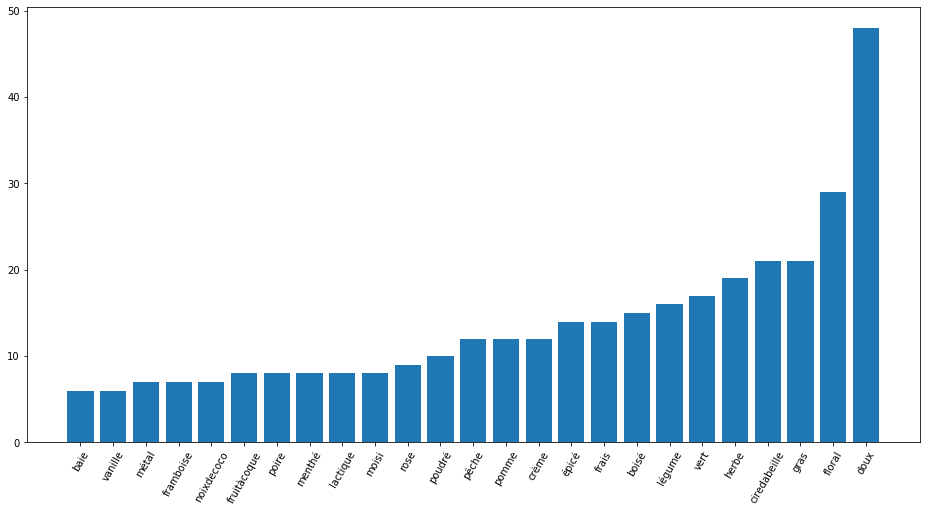

In [7]:
word="bois"
assert word in tokenizer.word_index, 'Word {} is not in the tokenizer'.format(word)
assert tokenizer.word_index[word] <= v_size, 'The word {} is an out of vocabuary word. Please try something else'.format(word)

rev_word_index = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))

#cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
cooc_vec = np.array(cooc_mat.getrow(2).todense()).ravel()
print(cooc_mat.getrow(122))
print(tokenizer.word_index[word])
print(cooc_mat.getrow(tokenizer.word_index[word]).todense())
max_ind = np.argsort(cooc_vec)[-25:]
print(max_ind)
plt.figure(figsize=(16,8))
print(cooc_vec)
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[rev_word_index[i] for i in max_ind], rotation=60)

In [8]:
def create_glove_model(v_size):    
    w_i = Input(shape=(1,))
    w_j = Input(shape=(1,))

    emb_i = Flatten()(Embedding(v_size, 96, input_length=1)(w_i))
    emb_j = Flatten()(Embedding(v_size, 96, input_length=1)(w_j))

    ij_dot = Dot(axes=-1)([emb_i,emb_j])
    
    b_i = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_i)
    )
    b_j = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_j)
    )

    pred = Add()([ij_dot, b_i, b_j])

    def glove_loss(y_true, y_pred):
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[w_i, w_j],outputs=pred)
    model.compile(loss=glove_loss, optimizer =Adam(lr=0.0001))
    return model


In [9]:
K.clear_session()
model = create_glove_model(v_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 96)        36576       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 96)        36576       input_2[0][0]                    
______________________________________________________________________________________________

In [10]:
cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
batch_size =128
copy_docs = list(docs)
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(10):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
        x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        """ For each batch in the dataset """
        model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))

C:\Users\Sebastien\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loss in epoch 0: 4.817571553850928
Loss in epoch 1: 0.3265313989360831
Loss in epoch 2: 0.07516575290148644
Loss in epoch 3: 0.0416386305463655
Loss in epoch 4: 0.024842339084939605
Loss in epoch 5: 0.014694050574885362
Loss in epoch 6: 0.008826712285359188
Loss in epoch 7: 0.005492256453220371
Loss in epoch 8: 0.0036027877034522987
Loss in epoch 9: 0.0024394837825941883


In [11]:
def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'embeddings_w.csv'), index=False, header=None
    )
    
save_embeddings(model, 'datasets', tokenizer, v_size)
model.save('glove_model.h5')

RuntimeError: Unable to create link (name already exists)

In [12]:

def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(120)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        
valid_words = get_valid_words(docs, 10, tokenizer)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w.csv'))
print(embed_mat)
print(words)
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('datasets','index2word.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))
    

Loading the word embeddings from the disk
Embedding shape: (381, 96)
[[-0.07979903  0.01566735 -0.01595545 ...  0.03066259 -0.03729701
  -0.01169676]
 [-0.01062449 -0.0122599   0.05350804 ...  0.05303592 -0.03916829
  -0.02151617]
 [-0.27708644 -0.44536912 -0.2714612  ... -0.3362836  -0.5444583
   0.5093356 ]
 ...
 [ 0.09658815  0.03245819  0.06856713 ...  0.04239238  0.0769246
  -0.08006772]
 [-0.03960428 -0.08021035 -0.04160608 ... -0.05268943 -0.0634671
  -0.0094806 ]
 [-0.00860529 -0.02402219  0.00495048 ...  0.0473998  -0.01299476
   0.01475223]]
['RESERVED' 'UNK' 'fruité' 'vert' 'doux' 'floral' 'boisé' 'herbe' 'épicé'
 'ciredabeille' 'gras' 'frais' 'agrume' 'balsamique' 'rose' 'fruitàcoque'
 'terre' 'huile' 'légume' 'crème' 'poudré' 'baie' 'menthé' 'pomme' 'moisi'
 'ananas' 'phénolé' 'camphre' 'soufré' 'aldéhyde' 'métal' 'miel' 'melon'
 'ambregris' 'raisin' 'caramel' 'oignon' 'banane' 'poire' 'café' 'vanille'
 'éther' 'fromage' 'vin' 'tabac' 'noixdecoco' 'jasmin' 'savon' 'ail'
 '

C:\Users\Sebastien\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Loading the word embeddings from the disk
Embedding shape: (381, 96)
[[0.00000000e+00 9.77049969e-01 1.13317354e+00 ... 1.19894155e+00
  9.64330821e-01 9.50015033e-01]
 [9.77049969e-01 0.00000000e+00 9.87511908e-01 ... 1.08999256e+00
  1.02998587e+00 9.05262688e-01]
 [1.13317354e+00 9.87511908e-01 1.11022302e-16 ... 1.01619511e+00
  1.09811496e+00 9.55091727e-01]
 ...
 [1.19894155e+00 1.08999256e+00 1.01619511e+00 ... 0.00000000e+00
  1.05852133e+00 1.12239628e+00]
 [9.64330821e-01 1.02998587e+00 1.09811496e+00 ... 1.05852133e+00
  0.00000000e+00 9.08993857e-01]
 [9.50015033e-01 9.05262688e-01 9.55091727e-01 ... 1.12239628e+00
  9.08993857e-01 0.00000000e+00]]
(381, 381)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 381 samples in 0.000s...
[t-SNE] Computed neighbors for 381 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 381 / 381
[t-SNE] Mean sigma: 0.191552
[t-SNE] Computed conditional probabilities in 0.021s
[t-SNE] Iteration 50: error = 86.81

C:\Users\Sebastien\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 65279 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Sebastien\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 65279 missing from current font.
  font.set_text(s, 0, flags=flags)


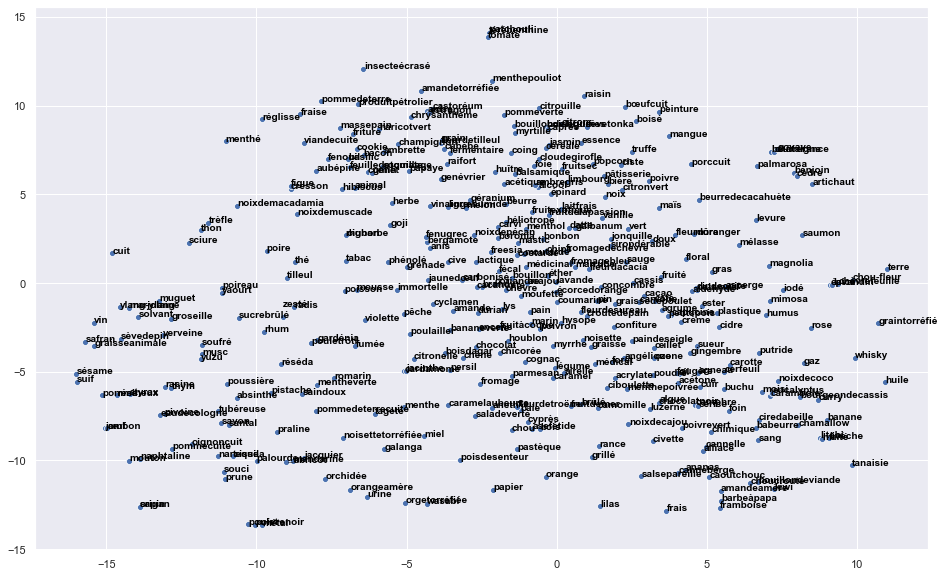

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import pairwise_distances
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
def getCosineMatrix(emb):
    matrix = pairwise_distances(emb,emb, metric='cosine', n_jobs=-1)
    return matrix
embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w.csv'))
cosine_matrix = getCosineMatrix(embed_mat)
print(cosine_matrix)
print(cosine_matrix.shape)

tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=30,learning_rate=500)
X_embedded = tsne.fit_transform(cosine_matrix)

df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')



In [24]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
print(X)
X.shape
y.shape


[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


(1797,)

breaking at iteration 12 with stress 4257.62449650373
breaking at iteration 14 with stress 4259.371816867814
breaking at iteration 14 with stress 4253.6836068225975
breaking at iteration 17 with stress 4253.513853716039


C:\Users\Sebastien\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 65279 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Sebastien\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 65279 missing from current font.
  font.set_text(s, 0, flags=flags)


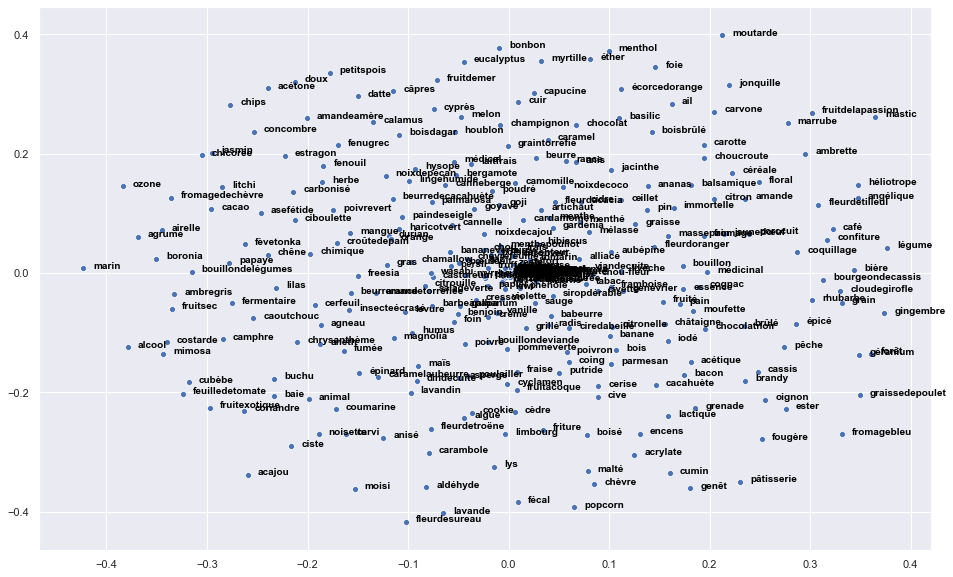

In [37]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,verbose=1,dissimilarity='precomputed')
X_transformed = embedding.fit_transform(cosine_matrix)
X_transformed.shape


df_subset2 = {} 
df_subset2['mds-2d-one'] = X_transformed[:,0]
df_subset2['mds-2d-two'] = X_transformed[:,1]
plt.figure(figsize=(16,10))
p2 = sns.scatterplot(X_transformed[:,0], X_transformed[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p2.text(df_subset2['mds-2d-one'][line]+0.01, df_subset2['mds-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')
